In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

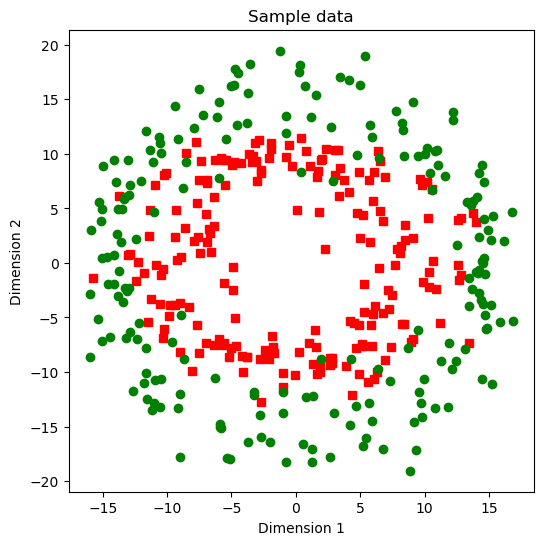

In [5]:
n_per_cluster = 200

theta = np.linspace(0, 4*np.pi, n_per_cluster)
r1 = 10
r2 = 15

a = [ r1*np.cos(theta) + np.random.randn(n_per_cluster)*3 ,
      r1*np.sin(theta) + np.random.randn(n_per_cluster) ]
b = [ r2*np.cos(theta) + np.random.randn(n_per_cluster) ,
      r2*np.sin(theta) + np.random.randn(n_per_cluster)*3 ]

labels_np = np.vstack((np.zeros((n_per_cluster,1)),np.ones((n_per_cluster,1))))

data_np = np.hstack((a,b)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

fig = plt.figure(figsize=(6,6))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'rs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'go')
plt.title("Sample data")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [7]:
class model(nn.Module):
    def __init__(self, dropout):
        super().__init__()

        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

        self.dropout = dropout

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.output(x)

        return x


In [8]:
def create_model(dropout):
    ANNQC = model(dropout)
    loss_fun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=.002)
    return ANNQC, loss_fun, optimizer

In [9]:
epochs = 1000

def train_model(ANNQC, loss_fun, optimizer):
    train_acc = []
    test_acc = []


    for i in range(epochs):
        ANNQC.train()
        batch_acc = []
        for X, y in train_loader:
            y_hat = ANNQC(X)
            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(100*torch.mean(((y_hat>.5)==y).float()).item())
        
        train_acc.append(np.mean(batch_acc))

        ANNQC.eval()
        X, y = next(iter(test_loader))
        y_hat = ANNQC(X)
        test_acc.append(100*torch.mean(((y_hat>.5)==y).float()).item())

    return train_acc, test_acc

In [13]:
DROPOUT = 0.2
ANNQC, loss_fun, optimizer = create_model(DROPOUT)
train_acc, test_acc = train_model(ANNQC, loss_fun, optimizer)

In [14]:
# create a 1D smoothing filter
def smooth(x, k=5):
  return np.convolve(x, np.ones(k)/k, mode='same')

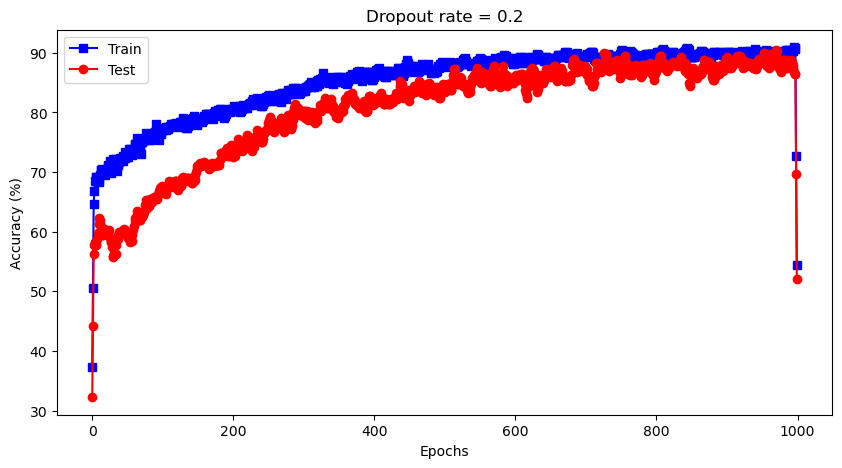

In [15]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(train_acc),'bs-')
plt.plot(smooth(test_acc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title(f'Dropout rate = {DROPOUT}')

plt.show()

In [17]:
# run an experiment (note: takes ~3.5 mins)

dropout_rates = np.arange(10)/10
results = np.zeros((len(dropout_rates),2))

for di in range(len(dropout_rates)):

  ANNQC,loss_fun,optimizer = create_model(dropout_rates[di])
  train_acc,test_acc = train_model(ANNQC,loss_fun,optimizer)

  results[di,0] = np.mean(train_acc[-100:])
  results[di,1] = np.mean(test_acc[-100:])


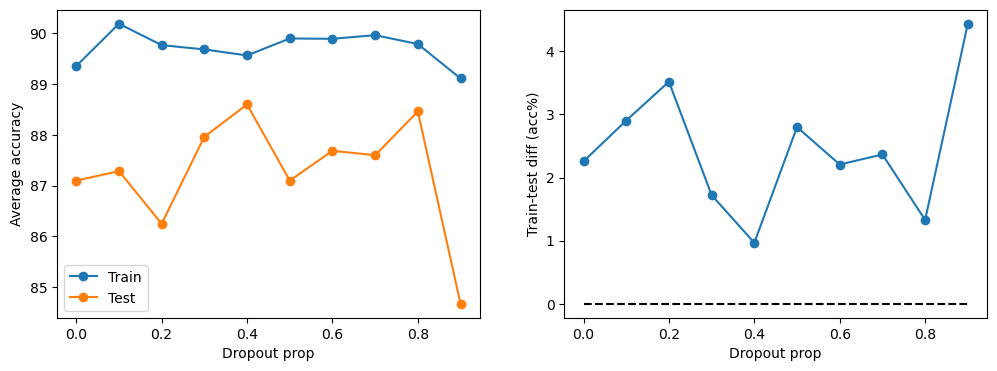

In [20]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(dropout_rates,results,'o-')
ax[0].set_xlabel('Dropout prop')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropout_rates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout prop')
ax[1].set_ylabel('Train-test diff (acc%)')

plt.show()